In [1]:

import jax
import mmml
import numpy as np
import matplotlib.pyplot as plt
print(jax.devices())
data = np.load("dataset1.npz", allow_pickle=True)
data.keys()

[CudaDevice(id=0)]


KeysView(NpzFile 'dataset1.npz' with keys: R, Z, D, Ef, E)

(array([1.000e+00, 2.000e+00, 4.000e+00, 2.200e+01, 1.100e+02, 3.610e+02,
        1.406e+03, 5.138e+03, 2.812e+03, 1.440e+02]),
 array([-9.02483342, -7.82961667, -6.63439991, -5.43918315, -4.24396639,
        -3.04874964, -1.85353288, -0.65831612,  0.53690063,  1.73211739,
         2.92733415]),
 <BarContainer object of 10 artists>)

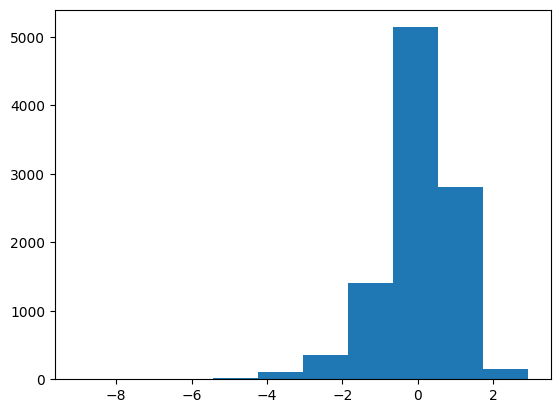

In [2]:
plt.hist(data["E"])

In [3]:
from training import *

# Option 1: Use all defaults
args = get_args()

# Option 2: Override specific parameters
args = get_args(
    data="data-full.npz",
    features=32,
    max_degree=4,
    num_iterations=2,
    num_basis_functions=16,
    cutoff=10.0,
    num_train=8000,
    num_valid=1000,
    num_epochs=200,
    learning_rate=0.0001,
    batch_size=50,
    clip_norm=100.0,
    ema_decay=0.5,
    early_stopping_patience=None,
    early_stopping_min_delta=0.0,
    reduce_on_plateau_patience=5,
    reduce_on_plateau_cooldown=5,
    reduce_on_plateau_factor=0.9,
    reduce_on_plateau_rtol=1e-4,
    reduce_on_plateau_accumulation_size=5,
    reduce_on_plateau_min_scale=0.01,
    energy_weight=1.0,
    forces_weight=1000.0,
    dipole_weight=20.0,
    dipole_field_coupling=False,
    field_scale=0.001,
)

# Print arguments to verify
print("Arguments:")
for arg in vars(args):
    print(f"  {arg}: {getattr(args, arg)}")

# Then use args as before - the rest of your code works the same way
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
dataset = np.load(args.data, allow_pickle=True)
train_data, valid_data = prepare_datasets(
    data_key, num_train=args.num_train, num_valid=args.num_valid, dataset=dataset
)

print("\nPrepared data shapes:")
print(f"  train atomic_numbers: {train_data['atomic_numbers'].shape}")
print(f"  train positions:      {train_data['positions'].shape}")
print(f"  train electric_field: {train_data['electric_field'].shape}")
print(f"  train energies:       {train_data['energies'].shape}")
print(f"  train forces:        {train_data['forces'].shape}")


CUDA graph capture is not supported in this JAX version
JAX devices: [CudaDevice(id=0)]
Dataset keys: ['R', 'Z', 'D', 'E', 'F', 'P', 'Ef']
Arguments:
  data: data-full.npz
  features: 32
  max_degree: 4
  num_iterations: 2
  num_basis_functions: 16
  cutoff: 10.0
  num_train: 8000
  num_valid: 1000
  num_epochs: 200
  learning_rate: 0.0001
  batch_size: 50
  clip_norm: 100.0
  ema_decay: 0.5
  early_stopping_patience: None
  early_stopping_min_delta: 0.0
  reduce_on_plateau_patience: 5
  reduce_on_plateau_cooldown: 5
  reduce_on_plateau_factor: 0.9
  reduce_on_plateau_rtol: 0.0001
  reduce_on_plateau_accumulation_size: 5
  reduce_on_plateau_min_scale: 0.01
  energy_weight: 1.0
  forces_weight: 1000.0
  dipole_weight: 20.0
  dipole_field_coupling: False
  field_scale: 0.001

Prepared data shapes:
  train atomic_numbers: (8000, 29)
  train positions:      (8000, 29, 3)
  train electric_field: (8000, 3)
  train energies:       (8000,)
  train forces:        (8000, 29, 3)


# Training

In [4]:
message_passing_model = MessagePassingModel(
    features=args.features,
    max_degree=args.max_degree,
    num_iterations=args.num_iterations,
    num_basis_functions=args.num_basis_functions,
    cutoff=args.cutoff,
    dipole_field_coupling=args.dipole_field_coupling,
    field_scale=args.field_scale,
)

# Generate UUID for this training run
run_uuid = str(uuid.uuid4())
print(f"\n{'='*60}")
print(f"Training Run UUID: {run_uuid}")
print(f"{'='*60}\n")

params = train_model(
    key=train_key,
    model=message_passing_model,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=args.num_epochs,
    learning_rate=args.learning_rate,
    batch_size=args.batch_size,
    clip_norm=args.clip_norm,
    ema_decay=args.ema_decay,
    early_stopping_patience=args.early_stopping_patience,
    early_stopping_min_delta=args.early_stopping_min_delta,
    reduce_on_plateau_patience=args.reduce_on_plateau_patience,
    reduce_on_plateau_cooldown=args.reduce_on_plateau_cooldown,
    reduce_on_plateau_factor=args.reduce_on_plateau_factor,
    reduce_on_plateau_rtol=args.reduce_on_plateau_rtol,
    reduce_on_plateau_accumulation_size=args.reduce_on_plateau_accumulation_size,
    reduce_on_plateau_min_scale=args.reduce_on_plateau_min_scale,
    energy_weight=args.energy_weight,
    forces_weight=args.forces_weight,
    dipole_weight=args.dipole_weight,
)

# Prepare model config
model_config = {
    'uuid': run_uuid,
    'model': {
        'features': args.features,
        'max_degree': args.max_degree,
        'num_iterations': args.num_iterations,
        'num_basis_functions': args.num_basis_functions,
        'cutoff': args.cutoff,
        'max_atomic_number': 55,  # Fixed in model
        'include_pseudotensors': True,  # Fixed in model
        'dipole_field_coupling': args.dipole_field_coupling,
        'field_scale': args.field_scale,
    },
    'training': {
        'num_train': args.num_train,
        'num_valid': args.num_valid,
        'num_epochs': args.num_epochs,
        'learning_rate': args.learning_rate,
        'batch_size': args.batch_size,
        'clip_norm': args.clip_norm,
        'ema_decay': args.ema_decay,
        'early_stopping_patience': args.early_stopping_patience,
        'early_stopping_min_delta': args.early_stopping_min_delta,
        'reduce_on_plateau_patience': args.reduce_on_plateau_patience,
        'reduce_on_plateau_cooldown': args.reduce_on_plateau_cooldown,
        'reduce_on_plateau_factor': args.reduce_on_plateau_factor,
        'reduce_on_plateau_rtol': args.reduce_on_plateau_rtol,
        'reduce_on_plateau_accumulation_size': args.reduce_on_plateau_accumulation_size,
        'reduce_on_plateau_min_scale': args.reduce_on_plateau_min_scale,
        'energy_weight': args.energy_weight,
        'forces_weight': args.forces_weight,
        'dipole_weight': args.dipole_weight,
    },
    'data': {
        'dataset': args.data,
    }
}

# Save config file
config_filename = f'config-{run_uuid}.json'
with open(config_filename, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"\n✓ Model config saved to {config_filename}")

# Save parameters with UUID
params_filename = f'params-{run_uuid}.json'
params_dict = to_jsonable(params)
with open(params_filename, 'w') as f:
    json.dump(params_dict, f)
print(f"✓ Parameters saved to {params_filename}")

# Also save symlinks for convenience (params.json and config.json)
try:
    if Path('params.json').exists():
        Path('params.json').unlink()
    if Path('config.json').exists():
        Path('config.json').unlink()
    Path('params.json').symlink_to(params_filename)
    Path('config.json').symlink_to(config_filename)
    print(f"✓ Created symlinks: params.json -> {params_filename}")
    print(f"✓ Created symlinks: config.json -> {config_filename}")
except Exception as e:
    print(f"Note: Could not create symlinks: {e}")

print(f"\n{'='*60}")
print(f"Training complete!")
print(f"UUID: {run_uuid}")
print(f"Config: {config_filename}")
print(f"Params: {params_filename}")
print(f"{'='*60}")



Training Run UUID: d0a93860-d514-4180-97e2-82bb2709b05b

    valid batch atomic_numbers: Array[1450] i32 5.7Kb x∈[1, 16] μ=4.000 σ=4.094 gpu:0
    valid batch positions: Array[1450, 3] n=4350 (17Kb) x∈[-4.267, 4.264] μ=0.054 σ=1.815 gpu:0
    valid batch energies: Array[50] x∈[-121.423, -120.578] μ=-120.862 σ=0.191 gpu:0
    valid batch forces: Array[1450, 3] n=4350 (17Kb) x∈[-0.079, 0.088] μ=2.055e-11 σ=0.017 gpu:0
    valid batch electric_field: Array[50, 3] n=150 x∈[-112.000, 101.000] μ=-3.040 σ=29.629 gpu:0
    valid batch dst_idx_flat: Array[40600] i32 0.2Mb x∈[0, 1449] μ=724.500 σ=418.579 gpu:0
    valid batch src_idx_flat: Array[40600] i32 0.2Mb x∈[0, 1449] μ=724.500 σ=418.579 gpu:0
    valid batch batch_segments: Array[1450] i32 5.7Kb x∈[0, 49] μ=24.500 σ=14.431 gpu:0
    valid batch dipoles: Array[50, 3] n=150 x∈[-5.681, 7.840] μ=0.550 σ=2.861 gpu:0
epoch:   1                    train:   valid:
    loss [a.u.]             Array gpu:0 6.915e+03 Array gpu:0 6.188e+03
    energy

In [6]:
# evaluate.py
from evaluate import *
args = get_args(
    params="params-d0a93860-d514-4180-97e2-82bb2709b05b.json",
    data="data-full.npz",
    batch_size=100,
    output_dir="results"
)

In [7]:
main(args)

TypeError: main() takes 0 positional arguments but 1 was given